In [26]:
%matplotlib inline
import math
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
import skimage.io

In [27]:
def show(images) :
    if type(images) is np.ndarray:
        images = [images]
    l = len(images)
    fig = plt.figure()
    fig.set_size_inches(20,20)
    for i,image in enumerate(images):
        fig.add_subplot(1, l, i+1)
        if len(image.shape) == 3:
            plt.imshow(image)
        else:
            plt.imshow(image, cmap='gray')
          
    plt.show()


In [28]:
# returns frame number n from clip
def get_frame_number(clip, n) :
    frame = clip.get_frame(float(n)/clip.fps)
    return frame

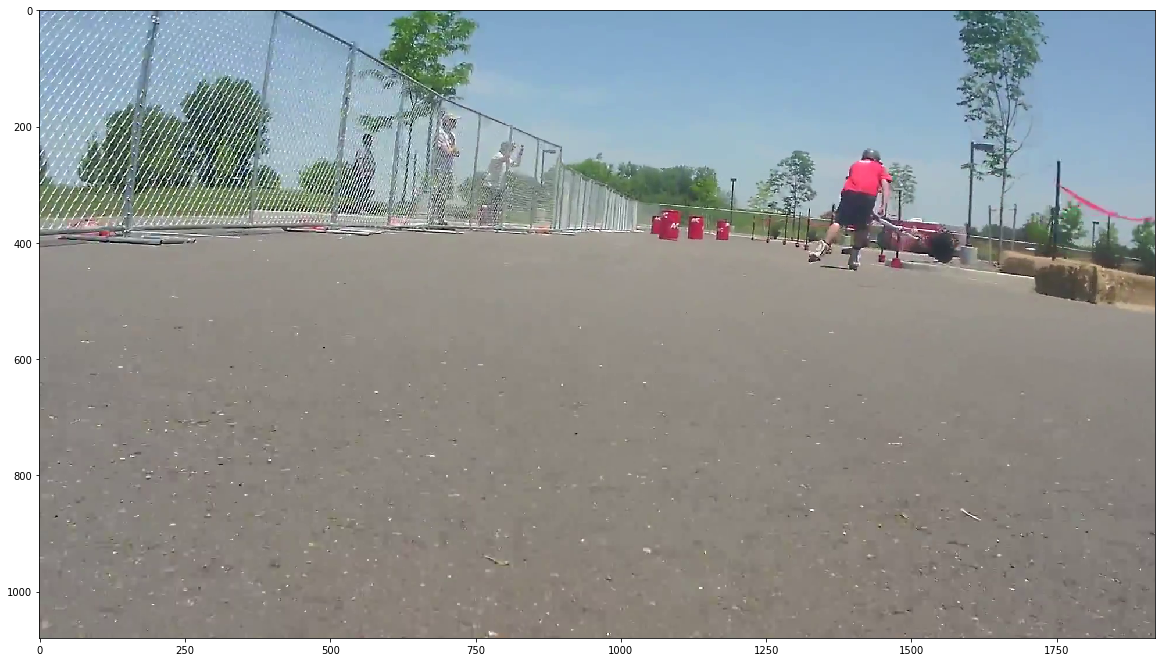

In [53]:
#im = cv2.imread('input/red_barrels_3.png')
clip = VideoFileClip('videos/video2.mp4')
im = clip.get_frame(15.0)
show(im)

In [54]:
#cv2.imwrite('input/red_barrels4.png', cv2.cvtColor(im, cv2.COLOR_RGB2BGR))

In [55]:
def split_up(min,max,ticks):
    return [int(min + (max-min) * i / float(ticks)) for i in range(ticks+1)]

In [56]:
def draw_vanishing_lines(im, vanishing_point_xy):
    im_h, im_w, _ = im.shape
    radius = 10
    thickness = 3

    color = (50,50,255,100)

    im = cv2.circle(im,vanishing_point_xy,radius,color)

    for x in split_up(0-5000,im_w+5000,ticks=30):
      cv2.line(im, (x,im_h), vanishing_point_xy, color)


In [57]:
# returns a binary mask where everything red in im is 1 and everything else is 0
def get_red_mask(im, min_red = 50, max_blue = 0.5, max_green = 0.5):
    if min_red is None:
        min_red = 50
    if max_blue is None:
        max_blue = 0.9
    if max_green is None:
        max_green = 0.3

    r,g,b = cv2.split(im);
    # lower mask (0-10)
    #lower_red = np.array([50,0,0])
    #upper_red = np.array([255,75,100])
    #im_mask = cv2.inRange(im, lower_red, upper_red)
    im_mask = (r * max_blue > b) * (r * max_green > g) * (r>min_red)
    return np.array(im_mask,dtype=np.uint8)

# returns a binary mask where everything that is likely to be a barrel is set to 1
def get_barrel_mask(im, min_red=None, max_green=None, max_blue = None):
    im_mask = get_red_mask(im, min_red=min_red, max_green=max_green, max_blue=max_blue)
    kernel = np.ones((11,11),np.uint8)
    kernel_vert = np.ones((11,1), np.uint8)
    
    center = (5,5)
    center_vert = (0,5)
    # get rid of small pieces of red
    im_mask = cv2.erode(im_mask, kernel, anchor=center, borderType=cv2.BORDER_CONSTANT, borderValue = 0)
    im_mask =cv2.dilate(im_mask, kernel, anchor=center, borderType=cv2.BORDER_CONSTANT, borderValue = 0)
    
    # connect vertically, this helps remove the white writing in the barrels
    im_mask =cv2.dilate(im_mask, kernel_vert, anchor=center_vert, iterations=6, borderType=cv2.BORDER_CONSTANT, borderValue = 0)
    im_mask = cv2.erode(im_mask, kernel_vert, anchor=center_vert, iterations=6, borderType=cv2.BORDER_CONSTANT, borderValue = 0)

    return im_mask


In [58]:
# returns a copy of im masked by mask
def mask_image(im, mask):
    im_out = im.copy()
    im_out[np.where(mask==0)] = 0
    return im_out


In [59]:
def find_red(im, min_red = None, max_green=None, max_blue = None):
    return mask_image(im, get_red_mask(im, min_red=min_red, max_green=max_green, max_blue=max_blue))

In [60]:
def find_red_barrels(im, min_red = None, max_green=None, max_blue = None):
    return mask_image(im, get_barrel_mask(im, min_red=min_red, max_green=max_green, max_blue=max_blue))

In [61]:
def show_red_barrels(min_red = None, max_green = None, max_blue = None):
    im_red = find_red(im, min_red, max_green, max_blue)
    im_barrels = find_red_barrels(im, min_red, max_green, max_blue)
    show([im, im_red, im_barrels])


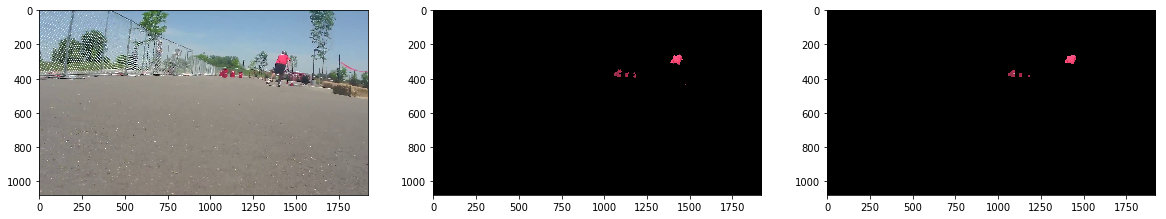

In [62]:
# see https://blog.dominodatalab.com/interactive-dashboards-in-jupyter/
from ipywidgets import widgets 
widgets.interact(
    show_red_barrels, 
    min_red = widgets.IntSlider(min=1,max=255,step=10, value=101), 
    max_green = widgets.FloatSlider(min = 0., max= 1., step=0.1, value=0.3),
    max_blue = widgets.FloatSlider(min=0.,max=1.,step=0.1,value=0.9));

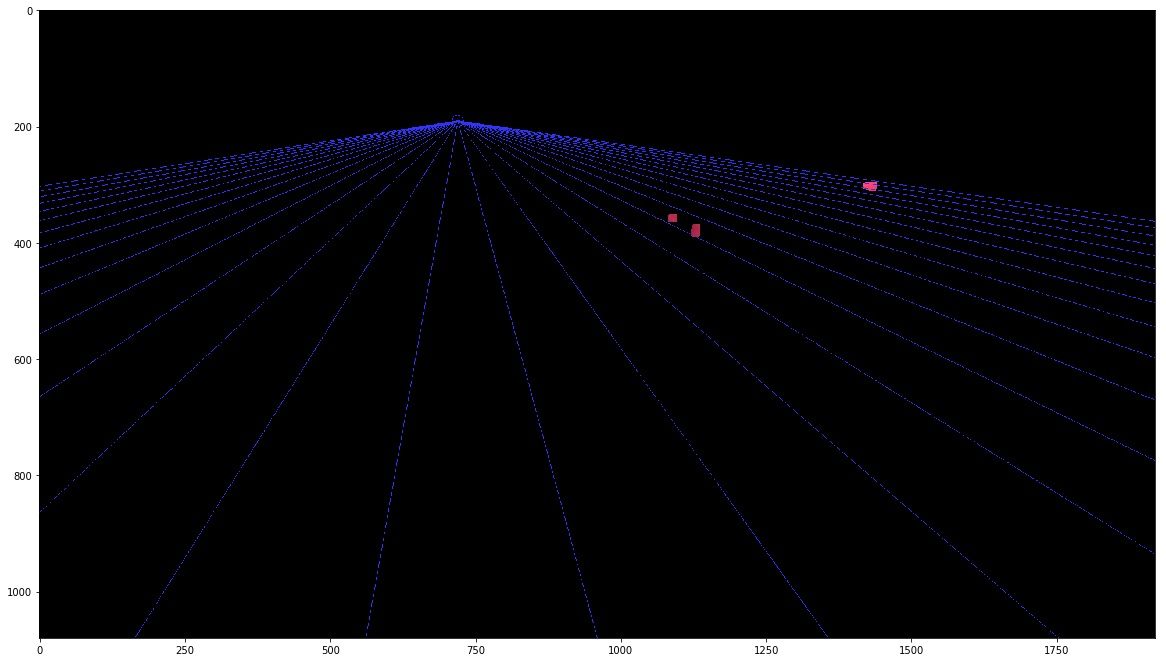

In [63]:
im_barrels = find_red_barrels(im)
vanishing_point_xy = (720,190) 
horizon = vanishing_point_xy[1]
draw_vanishing_lines(im_barrels, vanishing_point_xy)
show([im_barrels])

In [68]:
# top of barrel should be above horizon, bottom of barrel should be below horizon
# middle of barrel should be above horizon

In [69]:
def describe_keypoints(keypoints):
    for k in keypoints:
        print('angle', k.angle)
        print('class_id',k.class_id)
        print('octave', k.octave)
        print('pt',k.pt)
        print('response',k.response)
        print('size',k.size)
        print()

# describe_keypoints(keypoints)

In [70]:
def circularity(contour):
    perimeter = cv2.arcLength(contour, True)
    return 4 * math.pi * cv2.contourArea(contour) / (perimeter * perimeter)


In [71]:
def centroid(contour):
    M = cv2.moments(contour)
    cx = int(M['m10']/M['m00'])
    cy = int(M['m01']/M['m00'])
    return (cx, cy)
    

In [72]:
# draws barrel information on im 
def annotate_red_barrels(im):
    im_mask = get_barrel_mask(im)
    im_draw = im.copy()
    # see http://docs.opencv.org/3.1.0/dd/d49/tutorial_py_contour_features.html
    im_,contours,hierarchy = cv2.findContours(im_mask,cv2.RETR_TREE ,2)

    for contour, i in zip(contours,range(len(contours))):
        area = cv2.contourArea(contour)
        if area < 15*15:
            continue
        x,y,w,h = cv2.boundingRect(contour)
        if w > h:
            continue
        cv2.rectangle(im_draw, (x,y), (x+w, y+h),(0,255,0),2)
        hull = cv2.convexHull(contour,contour)
        cv2.drawContours(im_draw,[hull],0,(0,0,255),2)
        #if(len(contour)>=5): 
        #    e = cv2.fitEllipse(contour)
        #    cv2.ellipse(im_draw, e, (255,255,155))
    return im_draw

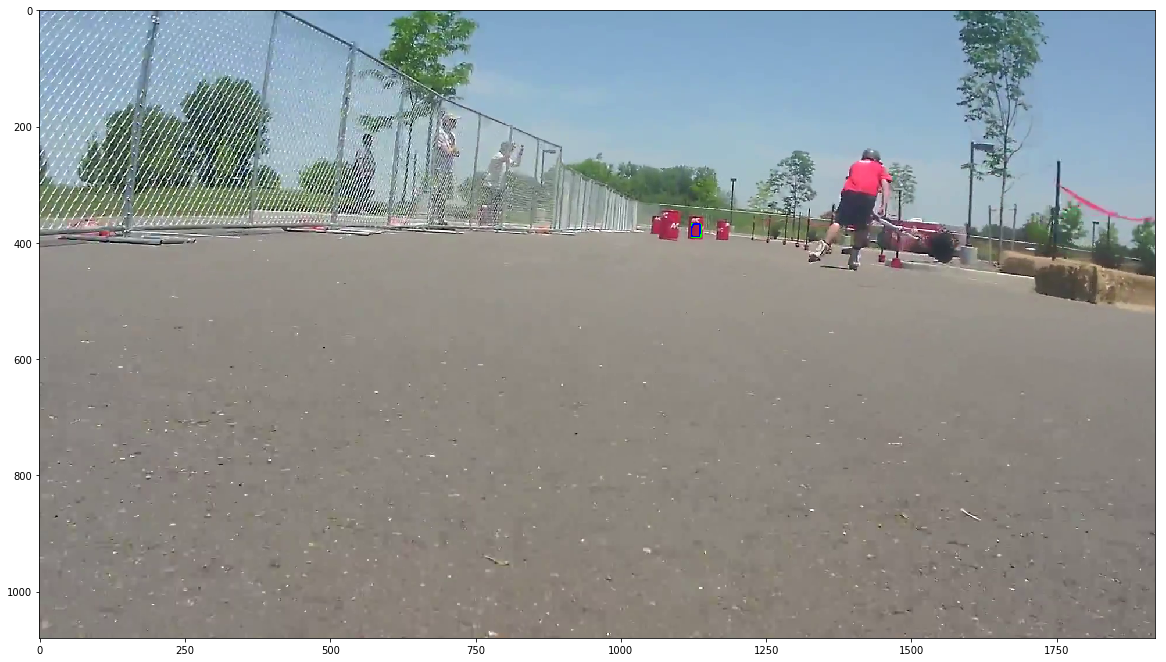

In [73]:
show(annotate_red_barrels(im))

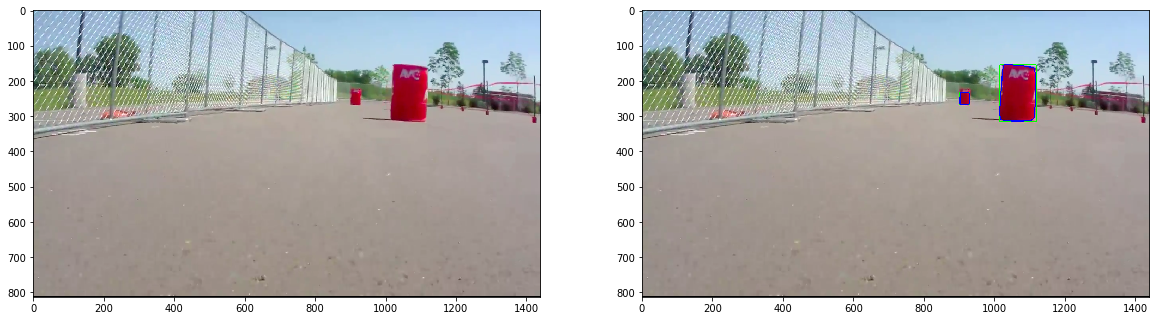

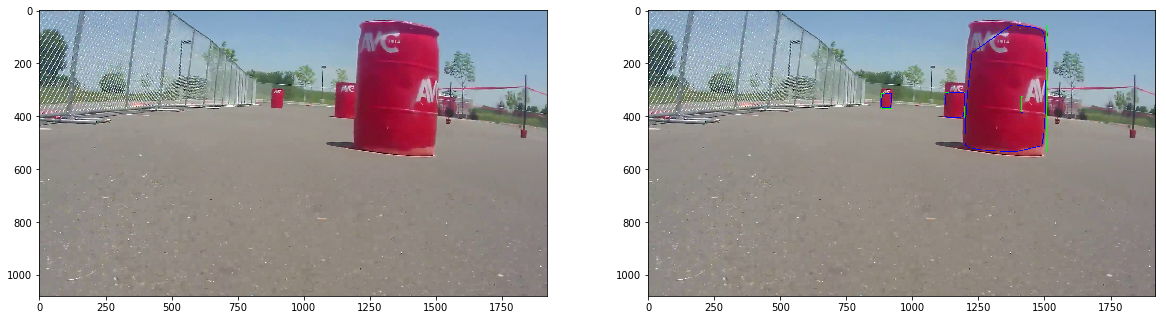

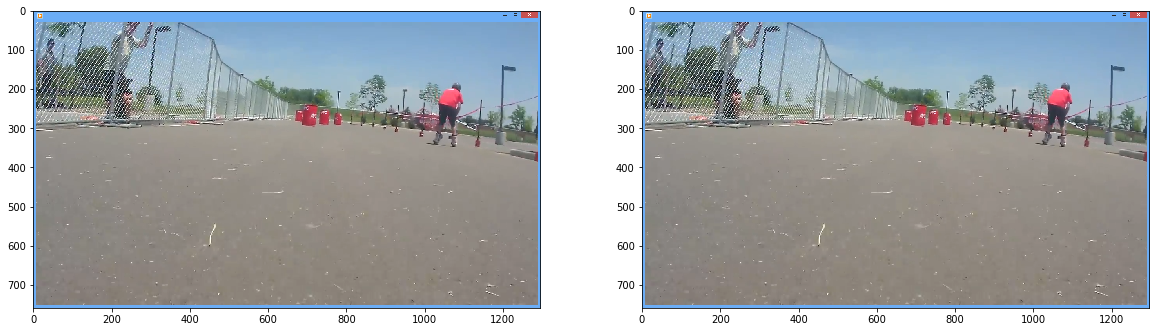

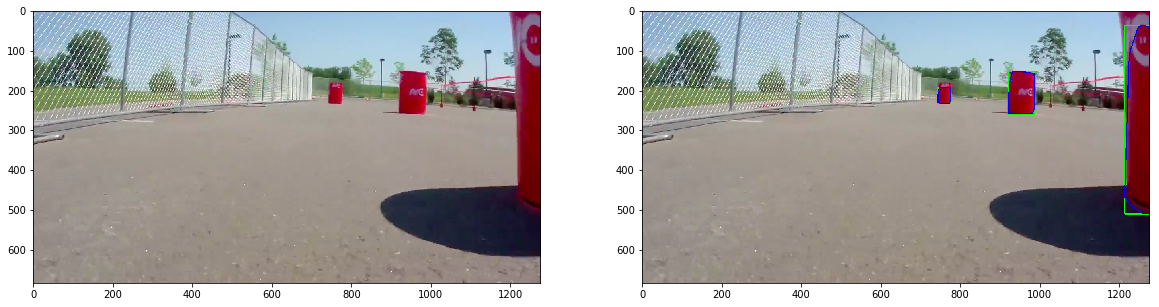

In [74]:
import glob
test_image_paths = glob.glob('input/red_barrels*.png')
for test_image_path in test_image_paths:
    im = cv2.cvtColor(cv2.imread(test_image_path), cv2.COLOR_BGR2RGB)
    im_annotated = annotate_red_barrels(im)
    show([im,im_annotated])
    
    

In [75]:
input_path='videos/video1.mp4'
output_path = 'output/video1.mp4'
clip1 = VideoFileClip(input_path)
clip = clip1.fl_image(annotate_red_barrels)
%time clip.write_videofile(output_path, audio=False, fps=5)

[MoviePy] >>>> Building video output/video1.mp4
[MoviePy] Writing video output/video1.mp4


100%|██████████| 329/329 [00:14<00:00, 22.45it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output/video1.mp4 

CPU times: user 51.6 s, sys: 804 ms, total: 52.4 s
Wall time: 15.4 s


In [76]:
vinput_path='videos/video2.mp4'
output_path = 'output/video2.mp4'
clip1 = VideoFileClip(input_path)
clip = clip1.fl_image(annotate_red_barrels)
%time clip.write_videofile(output_path, audio=False, fps=5)

[MoviePy] >>>> Building video output/video2.mp4
[MoviePy] Writing video output/video2.mp4


100%|██████████| 329/329 [00:14<00:00, 22.21it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output/video2.mp4 

CPU times: user 52 s, sys: 872 ms, total: 52.9 s
Wall time: 15.5 s
